# Big Data - TP #2

El objetivo de este TP es hacer una limpieza y análisis de la EPH. Asimismo, predecir si una persona es o no pobre
utilizando datos distintos al ingreso usando las metodologías vistas en clase.

In [2]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import statsmodels.api as sm     

from sklearn import datasets
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, recall_score 
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import RocCurveDisplay
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.impute import SimpleImputer

## Parte I: Analizando la base

In [3]:
# Abrimos el archivo y vemos las primeras cinco filas
eph_indiv = pd.read_excel("../datasets/usu_individual_T123.xlsx")
eph_indiv.head(5)

,CODUSU,ANO4,TRIMESTRE,NRO_HOGAR,COMPONENTE,H15,REGION,MAS_500,AGLOMERADO,PONDERA,...,PDECIFR,ADECIFR,IPCF,DECCFR,IDECCFR,RDECCFR,GDECCFR,PDECCFR,ADECCFR,PONDIH
0,TQRMNORVWHLMKOCDEOHCH00720228,2023,1,1,5,0,44,N,91,112,...,10.0,9,79700.0,6,6.0,5,NaN,7.0,5,133
1,TQRMNOPSTHKMKPCDEOHCH00781447,2023,1,1,1,1,44,N,91,190,...,6.0,5,180000.0,9,10.0,9,NaN,10.0,9,200
2,TQRMNOQSXHMOKRCDEOHCH00803177,2023,1,1,1,1,44,N,91,134,...,8.0,8,145000.0,9,9.0,8,NaN,9.0,8,140
3,TQRMNOQSXHMOKRCDEOHCH00803177,2023,1,1,2,1,44,N,91,134,...,8.0,8,145000.0,9,9.0,8,NaN,9.0,8,140
4,TQRMNOQYTHMNKSCDEOHCH00803178,2023,1,1,1,1,44,N,91,120,...,12.0,12,0.0,12,12.0,12,NaN,12.0,12,0


In [4]:
#Resumen de la base de datos
eph_indiv.info(verbose = True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48638 entries, 0 to 48637
Data columns (total 177 columns):
 #    Column      Dtype  
---   ------      -----  
 0    CODUSU      object 
 1    ANO4        int64  
 2    TRIMESTRE   int64  
 3    NRO_HOGAR   int64  
 4    COMPONENTE  int64  
 5    H15         int64  
 6    REGION      int64  
 7    MAS_500     object 
 8    AGLOMERADO  int64  
 9    PONDERA     int64  
 10   CH03        int64  
 11   CH04        int64  
 12   CH05        object 
 13   CH06        int64  
 14   CH07        int64  
 15   CH08        float64
 16   CH09        int64  
 17   CH10        int64  
 18   CH11        int64  
 19   CH12        int64  
 20   CH13        int64  
 21   CH14        float64
 22   CH15        int64  
 23   CH15_COD    float64
 24   CH16        int64  
 25   CH16_COD    float64
 26   NIVEL_ED    int64  
 27   ESTADO      int64  
 28   CAT_OCUP    int64  
 29   CAT_INAC    int64  
 30   IMPUTA      float64
 31   PP02C1      int64  
 32   

In [5]:
#2a) Eliminen todas las observaciones que no corresponden a los aglomerados de CABA o Gran Buenos Aires.

#El siguiente código toma el índice de aquellas observaciones para las que el aglomerado no es ni CABA (32) ni Gran Buenos Aires (33), y elimina las filas que cumplen esa condición. 

eph_indiv= eph_indiv.drop(eph_indiv[(eph_indiv["AGLOMERADO"] != 32) & (eph_indiv["AGLOMERADO"] != 33)].index)

#Para comprobar que funcionó, presentamos los valores que toma la variable "AGLOMERADO":

unique=eph_indiv["AGLOMERADO"].unique() 
print(unique) #Vemos que ahora "Aglomerado" solo toma los valores 32 y 33

[33 32]


In [6]:
#2b) Si hay observaciones con valores que no tienen sentido, descartarlas

#Para identificar aquellas variables que toman valores sin sentido, utilizamos el siguiente comando:
# (Las funciones nanmin y nanmax calculan los valores mínimos y máximos de cada columna sin incluir los valores faltantes, ya que de lo contrario para las variables con valores faltantes "nan" aparece como el valor mínimo y máximo)

for column in eph_indiv.columns:
    try:
        print(column, np.nanmin(eph_indiv[column]), np.nanmax(eph_indiv[column]))
    except:
        print(column)
        

CODUSU TQRMNOPPQHJNOPCDEIJAH00802435 TQUMNORTQHLMNUCDEIJAH00780261
ANO4 2023 2023
TRIMESTRE 1 1
NRO_HOGAR 1 51
COMPONENTE 1 13
H15 0 2
REGION 1 1
MAS_500 S S
AGLOMERADO 32 33
PONDERA 45 8423
CH03 1 10
CH04 1 2
CH05 1900-01-01 00:00:00 2023-03-02 00:00:00
CH06 -1 99
CH07 1 9
CH08 1.0 12.0
CH09 0 9
CH10 0 9
CH11 0 9
CH12 0 99
CH13 0 9
CH14 0.0 99.0
CH15 0 9
CH15_COD 10.0 449.0
CH16 0 9
CH16_COD 14.0 410.0
NIVEL_ED 1 7
ESTADO 0 4
CAT_OCUP 0 9
CAT_INAC 0 7
IMPUTA 1.0 1.0
PP02C1 0 2
PP02C2 0 2
PP02C3 0 2
PP02C4 0 2
PP02C5 0 2
PP02C6 0 2
PP02C7 0 2
PP02C8 0 2
PP02E 0 5
PP02H 0 2
PP02I 0 2
PP03C 0.0 2.0
PP03D 0.0 6.0
PP3E_TOT 0.0 999.0
PP3F_TOT 0.0 999.0
PP03G 1.0 9.0
PP03H 0.0 9.0
PP03I 1.0 9.0
PP03J 1.0 9.0
INTENSI 1.0 4.0
PP04A 1.0 9.0
PP04B_COD 1.0 9999.0
PP04B1 1.0 2.0
PP04B2 0.0 6.0
PP04B3_MES 0.0 99.0
PP04B3_ANO 0.0 99.0
PP04B3_DIA 0.0 99.0
PP04C 0.0 99.0
PP04C99 0.0 9.0
PP04D_COD 1001.0 99999.0
PP04G 0.0 99.0
PP05B2_MES 0.0 99.0
PP05B2_ANO 0.0 99.0
PP05B2_DIA 0.0 99.0
PP05C_1 0.0 9.0


C:\Users\Ronny\AppData\Local\Temp\ipykernel_4804\375411686.py:8: RuntimeWarning: All-NaN axis encountered
  print(column, np.nanmin(eph_indiv[column]), np.nanmax(eph_indiv[column]))


In [7]:
#Eliminamos observaciones con edades (CH06) menores a 0:
eph_indiv= eph_indiv.drop(eph_indiv[(eph_indiv["CH06"] <0)].index)

#Las variables de ingreso IPCF e ITF no toman valores negativos.

#Reemplazamos los 9, 99, 999, 9999, 99999 por "nan" en aquellas variables en las que dichos codigos corresponden a valores faltantes.

missing_codes= [9, 99, 999, 9999, 99999]

for i in missing_codes:
    for column in eph_indiv.columns:
        if column!="CH06":
            try:
                if np.nanmax(eph_indiv[column])==i:
                    eph_indiv[column]=eph_indiv[column].replace(i, np.nan)
            except:
                print(column, eph_indiv[column].dtype) 

PP09A_ESP object


PP09C_ESP object
PP09A_ESP object
PP09C_ESP object
PP09A_ESP object
PP09C_ESP object
PP09A_ESP object
PP09C_ESP object
PP09A_ESP object
PP09C_ESP object


C:\Users\Ronny\AppData\Local\Temp\ipykernel_4804\2624756829.py:14: RuntimeWarning: All-NaN axis encountered
  if np.nanmax(eph_indiv[column])==i:


In [8]:
#Verificamos que se haya filtrado:

for column in eph_indiv.columns:
    try:
        print(column, np.nanmin(eph_indiv[column]), np.nanmax(eph_indiv[column]))
    except:
        print(column)

CODUSU TQRMNOPPQHJNOPCDEIJAH00802435 TQUMNORTQHLMNUCDEIJAH00780261
ANO4 2023 2023
TRIMESTRE 1 1
NRO_HOGAR 1 51
COMPONENTE 1 13
H15 0 2
REGION 1 1
MAS_500 S S
AGLOMERADO 32 33
PONDERA 45 8423
CH03 1 10
CH04 1 2
CH05 1900-01-01 00:00:00 2022-03-18 00:00:00
CH06 1 99
CH07 1.0 5.0
CH08 1.0 12.0
CH09 1.0 3.0
CH10 0.0 3.0
CH11 0.0 2.0
CH12 0.0 9.0
CH13 0.0 2.0
CH14 0.0 98.0
CH15 1.0 5.0
CH15_COD 10.0 449.0
CH16 0.0 6.0
CH16_COD 14.0 410.0
NIVEL_ED 1 7
ESTADO 0 4
CAT_OCUP 0.0 4.0
CAT_INAC 0 7
IMPUTA 1.0 1.0
PP02C1 0 2
PP02C2 0 2
PP02C3 0 2
PP02C4 0 2
PP02C5 0 2
PP02C6 0 2
PP02C7 0 2
PP02C8 0 2
PP02E 0 5
PP02H 0 2
PP02I 0 2
PP03C 0.0 2.0
PP03D 0.0 6.0
PP3E_TOT 0.0 168.0
PP3F_TOT 0.0 56.0
PP03G 1.0 2.0
PP03H 0.0 3.0
PP03I 1.0 2.0
PP03J 1.0 2.0
INTENSI 1.0 4.0
PP04A 1.0 3.0
PP04B_COD 1.0 9900.0
PP04B1 1.0 2.0
PP04B2 0.0 6.0
PP04B3_MES 0.0 11.0
PP04B3_ANO 0.0 40.0
PP04B3_DIA 0.0 30.0
PP04C 0.0 12.0
PP04C99 0.0 3.0
PP04D_COD 1001.0 99998.0
PP04G 0.0 10.0
PP05B2_MES 0.0 6.0
PP05B2_ANO 0.0 10.0
PP05

C:\Users\Ronny\AppData\Local\Temp\ipykernel_4804\2269627186.py:5: RuntimeWarning: All-NaN axis encountered
  print(column, np.nanmin(eph_indiv[column]), np.nanmax(eph_indiv[column]))


Mujer    51.961432
Varón    48.038568
Name: gender, dtype: float64


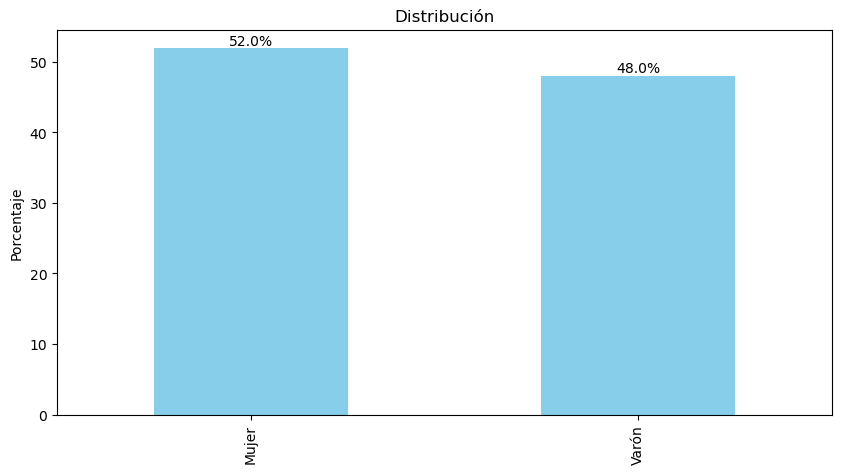

In [9]:
#2c) Gráfico de barras mostrando la composición por sexo
eph_indiv['gender'] = eph_indiv['CH04'].map({1: 'Varón', 2: 'Mujer'})
gender_counts = eph_indiv['gender'].value_counts(normalize=True) * 100
print(gender_counts) # Para conocer los porcentajes

# Gráfico de barras
barplot = plt.figure(figsize = (10, 5))
ax = gender_counts.plot(kind='bar', color='skyblue')
plt.title('Distribución')
plt.ylabel('Porcentaje')

# Agregamos etiqueta de porcentaje a cada barra
for i, v in enumerate(gender_counts):
    ax.text(i, v, f'{v:.1f}%', ha='center', va='bottom')

plt.show()

              CH04      CH07      CH08  NIVEL_ED    ESTADO  CAT_INAC      IPCF
CH04      1.000000 -0.000175 -0.019780  0.050053  0.111855  0.079618 -0.024220
CH07     -0.000175  1.000000  0.068998 -0.082108  0.417708  0.409669 -0.042780
CH08     -0.019780  0.068998  1.000000 -0.000644  0.019759  0.088826 -0.069497
NIVEL_ED  0.050053 -0.082108 -0.000644  1.000000 -0.205541 -0.045002  0.151222
ESTADO    0.111855  0.417708  0.019759 -0.205541  1.000000  0.822162 -0.107492
CAT_INAC  0.079618  0.409669  0.088826 -0.045002  0.822162  1.000000 -0.110865
IPCF     -0.024220 -0.042780 -0.069497  0.151222 -0.107492 -0.110865  1.000000


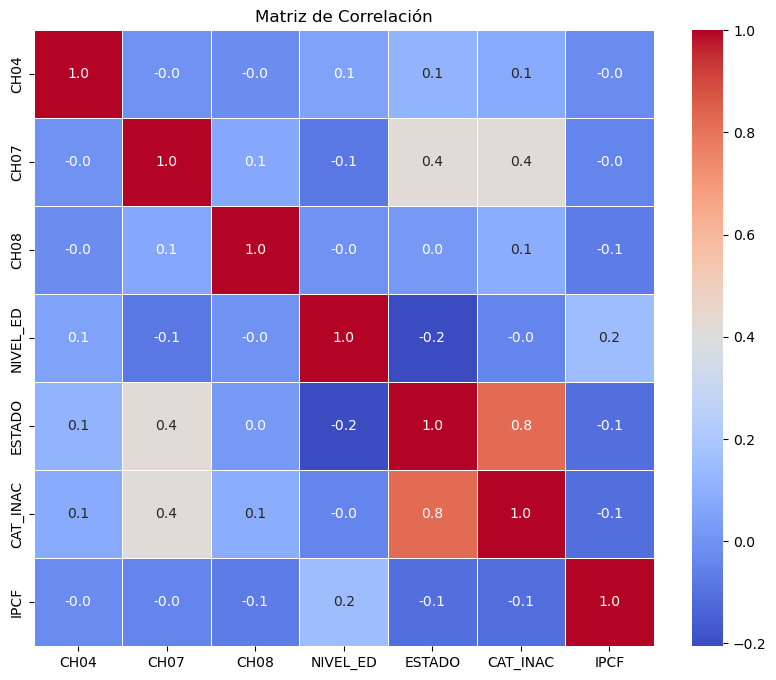

In [10]:
#2d) Matriz de correlación con las siguientes variables
covars = eph_indiv[['CH04', 'CH07', 'CH08', 'NIVEL_ED', 'ESTADO', 'CAT_INAC', 'IPCF']] # Variables
corr_matrix = covars.corr()
print(corr_matrix) #Matriz de correlación

# Ahora hacemos un gráfico usando la librería 'seaborn'
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap= "coolwarm", fmt=".1f", linewidths=0.5)
plt.title("Matriz de Correlación")
plt.show()

In [11]:
#2e) Calcular a los desocupados, inactivos y la media del Ingreso Per Capita Familiar segun estado (ocupado, desocupado, inactivo)

ocupados = (eph_indiv["ESTADO"] == 1).sum()
print("Número de ocupados en la muestra:" + str(ocupados))
desocupados=(eph_indiv["ESTADO"] == 2).sum()
print("Número de desocupados en la muestra:" + str(desocupados))
inactivos = (eph_indiv["ESTADO"] == 3).sum()
print("Número de inactivos en la muestra:" + str(inactivos))


#Para calcular el ingreso per capita para cada grupo, usamos la función loc, ya que necesitamos seleccionar una columna en particular para aquellas filas que cumplen cierta condición.

ingreso_ipcf_ocupados= eph_indiv.loc[eph_indiv["ESTADO"] == 1, "IPCF"].mean()
print("La media del IPCF para los ocupados es:" + str(ingreso_ipcf_ocupados))

ingreso_ipcf_desocupados= eph_indiv.loc[eph_indiv["ESTADO"] == 2, "IPCF"].mean()
print("La media del IPCF para los desocupados es:" + str(ingreso_ipcf_desocupados))

ingreso_ipcf_inactivos= eph_indiv.loc[eph_indiv["ESTADO"] == 3, "IPCF"].mean()
print("La media del IPCF para los inactivos es:" + str(ingreso_ipcf_inactivos))

Número de ocupados en la muestra:3523
Número de desocupados en la muestra:286
Número de inactivos en la muestra:2837
La media del IPCF para los ocupados es:59579.4429151292
La media del IPCF para los desocupados es:25536.02220279721
La media del IPCF para los inactivos es:40067.99605216777


In [12]:
#2f) 

#Abrimos el archivo "tabla adulto equiv.xlsx"

adulto = pd.read_excel("../datasets/tabla_adulto_equiv.xlsx")
display(adulto)


,"Tabla de equivalencias de necesidades energéticas. Unidades de adulto equivalente, según sexo y edad",Unnamed: 1,Unnamed: 2
0,NaN,NaN,NaN
1,NaN,NaN,NaN
2,Edad,Mujeres,Varones
3,NaN,NaN,NaN
4,Menor de 1 año,0.35,0.35
5,1 año,0.37,0.37
6,2 años,0.46,0.46
7,3 años,0.51,0.51
8,4 años,0.55,0.55
9,5 años,0.6,0.6


In [13]:
#Acomodamos la base:

adulto=adulto[4:27] #Nos quedamos solo con las celdas que nos interesan
adulto["Edad"]=adulto["Tabla de equivalencias de necesidades energéticas. Unidades de adulto equivalente, según sexo y edad"]
adulto["2"]=adulto["Unnamed: 1"]
adulto["1"]=adulto["Unnamed: 2"]
adulto= adulto[["Edad", "2", "1"]]
display(adulto)

adulto["Edad"]=adulto["Edad"].str.replace("años", "").str.replace("año", "").str.replace(" ", "").str.replace("a", "")
adulto = adulto.set_index("Edad")


display(adulto)

,Edad,2,1
4,Menor de 1 año,0.35,0.35
5,1 año,0.37,0.37
6,2 años,0.46,0.46
7,3 años,0.51,0.51
8,4 años,0.55,0.55
9,5 años,0.6,0.6
10,6 años,0.64,0.64
11,7 años,0.66,0.66
12,8 años,0.68,0.68
13,9 años,0.69,0.69


,2,1
Edad,,
Menorde1,0.35,0.35
1,0.37,0.37
2,0.46,0.46
3,0.51,0.51
4,0.55,0.55
5,0.6,0.6
6,0.64,0.64
7,0.66,0.66
8,0.68,0.68


In [14]:
#Chequeamos los valores que toman las variables de genero (CH04) y edad (CH06) en la base eph_indiv:
print(eph_indiv["CH04"].unique())
print(eph_indiv["CH06"].unique())

[2 1]
[65 70 36 28  9 59 55 18 44 45 10  3 62 67 53 51 29 39 24  6 34  4  1 52
 50 31 23 14  5 61 25 21 46 16 22 42 38 19 12 75 17 27 49 77 66  2 87 37
 48 78 74 90 13 71  7 41 47 33 63 72 35 86 92 82 58 69 30 57 85 80 79 68
 83 54 26 11 40 60 32 73 64  8 56 43 99 15 81 20 89 84 76 97 91 88 93 94
 95 96]


In [15]:
# Creamos la función "equivalencia" que asignará el factor de equivalencia correspondiente para cualquier combinación de edad y género
def equivalencia(edad, genero):
    if edad <18: #No hay observaciones con edades menor a 1, asi que la aquivalencia para las personas de menos de 1 año de edad no es un problema en este caso
        equiv= adulto.at[str(edad),str(genero)]
    if edad>=18 and edad <30:
        equiv= adulto.at["1829", str(genero)]
    if edad>=30 and edad <46:
        equiv= adulto.at["3045", str(genero)]   
    if edad>=46 and edad <61:
        equiv= adulto.at["4660", str(genero)]   
    if edad>=61 and edad <76: #No queda claro en la tabla, pero asumimos que las personas de 75 están incluidas en esta categoría
        equiv= adulto.at["6175", str(genero)]    
    if edad>=76:
        equiv= adulto.at["másde75", str(genero)] 
    return(equiv)  

eph_indiv["adulto_equiv"]= eph_indiv.apply(lambda x: equivalencia(x.CH06, x.CH04), axis=1)

In [16]:
#Visualizamos los resultados:
display(eph_indiv[["CH04", "CH06", "adulto_equiv"]])

,CH04,CH06,adulto_equiv
102,2,65,0.67
103,1,70,0.83
104,1,36,1.00
105,2,28,0.76
106,2,9,0.69
...,...,...,...
48597,2,77,0.63
48598,2,45,0.77
48599,1,17,1.04
48600,1,26,1.02


In [17]:
#Generamos una base que suma las equivalencias por hogar, y luego unimos esa base a la nuestra.

suma=eph_indiv.groupby(by=["CODUSU", "NRO_HOGAR"]).agg({"adulto_equiv":"sum"})
suma["ad_equiv_hogar"]=suma["adulto_equiv"]
suma = suma.drop('adulto_equiv', axis=1)
display(suma)

,,ad_equiv_hogar
CODUSU,NRO_HOGAR,
TQRMNOPPQHJNOPCDEIJAH00802435,1,3.54
TQRMNOPPQHKMQRCDEIJAH00780809,1,4.48
TQRMNOPPQHLNKTCDEIIAD00780107,1,2.14
TQRMNOPPQHLOKTCDEIJAH00719666,1,1.00
TQRMNOPPQHMKLSCDEIIAD00801791,1,1.41
...,...,...
TQTMNORTQHLMNUCDEIJAH00793701,1,3.58
TQTMNORTYHJOPMCDEIJAH00794674,1,1.78
TQUMNOQQUHKNRUCDEIJAH00780938,1,3.07


In [18]:
# Y hacemos un merge con el df "suma" que contiene la variable de factor de equivalencia por hogar (ad_equiv_hogar)
eph_indiv=eph_indiv.merge(suma, on=['CODUSU','NRO_HOGAR'], how='left')

In [19]:
#3) Chequeamos valores faltantes en la columna "ITF":

missing_values_ITF = eph_indiv['ITF'].isna().sum()
print(missing_values_ITF) #No hay valores faltantes

#Chequeamos observaciones para las que el ITF toma valor 0:

print((eph_indiv['ITF']==0).sum()) #3390

0
3390


In [20]:
#Guarden como una base distinta llamada respondieron las observaciones donde respondieron la pregunta sobre su ITF. 
#Las observaciones con ITF = 0 guardenlas en una base bajo el nombre norespondieron.

respondieron=eph_indiv[eph_indiv["ITF"]>0]
norespondieron=eph_indiv[eph_indiv["ITF"]==0]

In [21]:
#Comprobamos que en la base "respondieron" todos los valores de ITF sean mayores a 0, y que en la base "norespondieron" ITF tome solo valor 0.
print(respondieron["ITF"].describe())
print(norespondieron["ITF"].describe())

count    4.181000e+03
mean     2.503417e+05
std      4.194312e+05
min      2.500000e+03
25%      1.150000e+05
50%      1.800000e+05
75%      3.000000e+05
max      1.099000e+07
Name: ITF, dtype: float64
count    3390.0
mean        0.0
std         0.0
min         0.0
25%         0.0
50%         0.0
75%         0.0
max         0.0
Name: ITF, dtype: float64


In [22]:
#4)la Canasta Basica Total para un adulto equivalente en el GBA en el primer trimestre de 2023 es aproximadamente $57.371,05.
#Agreguen a la base respondieron una columna llamada ingreso necesario, que sea el producto de este valor por ad equiv hogar.
respondieron["ingreso_necesario"]= 57371.05*respondieron["ad_equiv_hogar"]
display(respondieron[["CODUSU", "NRO_HOGAR", "ingreso_necesario", "ad_equiv_hogar"]])

C:\Users\Ronny\AppData\Local\Temp\ipykernel_4804\1045893623.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  respondieron["ingreso_necesario"]= 57371.05*respondieron["ad_equiv_hogar"]


,CODUSU,NRO_HOGAR,ingreso_necesario,ad_equiv_hogar
0,TQRMNORUYHLMSMCDEIJAH00719364,1,86056.5750,1.50
1,TQRMNORUYHLMSMCDEIJAH00719364,1,86056.5750,1.50
2,TQRMNOSRQHJNSOCDEIJAH00802640,1,140559.0725,2.45
3,TQRMNOSRQHJNSOCDEIJAH00802640,1,140559.0725,2.45
4,TQRMNOSRQHJNSOCDEIJAH00802640,1,140559.0725,2.45
...,...,...,...,...
7562,TQRMNORTWHJMSTCDEIJAH00793919,1,219157.4110,3.82
7563,TQRMNOPVVHKLRQCDEIJAH00780546,1,141132.7830,2.46
7564,TQRMNOPVVHKLRQCDEIJAH00780546,1,141132.7830,2.46
7565,TQRMNOPVVHKLRQCDEIJAH00780546,1,141132.7830,2.46


In [23]:
#5) Agreguen a respondieron una columna llamada pobre que tome valor 1 si el ITF es menor al ingreso necesario que necesita esa familia, y 0 en caso contrario. 

respondieron["pobre"] = (respondieron["ITF"]< respondieron["ingreso_necesario"]).astype(int)

#"astype(int) convierte los valores "True" y "False" en 1 y 0

display (respondieron[["ITF", "ingreso_necesario", "pobre"]])

C:\Users\Ronny\AppData\Local\Temp\ipykernel_4804\3644306113.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  respondieron["pobre"] = (respondieron["ITF"]< respondieron["ingreso_necesario"]).astype(int)


,ITF,ingreso_necesario,pobre
0,135000,86056.5750,0
1,135000,86056.5750,0
2,70000,140559.0725,1
3,70000,140559.0725,1
4,70000,140559.0725,1
...,...,...,...
7562,155000,219157.4110,1
7563,480000,141132.7830,0
7564,480000,141132.7830,0
7565,480000,141132.7830,0


In [24]:
#¿Cuantos pobres identificaron?

pobres = (respondieron["pobre"] == 1).sum()
print("Número de pobres:" + str(pobres)) 

#Identificamos 1555 pobres, de un total de 4181 individuos que componen la base, es decir, 37,19% de pobres

Número de pobres:1555


## Parte II: Clasificación

El objetivo de esta parte del trabajo es intentar predecir la condición de pobreza utilizando datos distintos al ingreso, dado que muchos hogares son reacios a responder
cuánto ganan.

### Inciso 1: Preparación de la base de datos

In [25]:
# Eliminamos de ambas bases todas las variables relacionadas a ingresos, y también las columnas adulto equiv,, ad equiv hogar e ingreso necesario

# Todas las variables que borraremos de las dos bases: 
dropvars = ["PP08D1", "PP08D4", "PP08F1", "PP08F2", "PP08J1", "PP08J2", "PP08J3", #Ocupacion principal de asalariados
            "P21", "DECOCUR", "IDECOCUR", "RDECOCUR", "GDECOCUR", "PDECOCUR", "ADECOCUR", "PONDIIO", # Ocupación principal
            "TOT_P12", #Otra ocupaciones
            "P47T", "DECINDR", "IDECINDR", "RDECINDR", "GDECINDR", "PDECINDR", "ADECINDR", "PONDII", #Individual
            "V2_M", "V3_M", "V4_M", "V5_M", "V8_M", "V9_M", "V10_M", "V11_M", "V12_M", "V18_M", "V19_AM", "V21_M", "T_VI", #No laborales
            "ITF", "DECIFR", "IDECIFR", "RDECIFR", "GDECIFR", "PDECIFR", "ADECIFR", # Total Familiar
            "IPCF", "DECCFR", "IDECCFR", "RDECCFR", "GDECCFR", "PDECCFR", "ADECCFR", "PONDIH", #Per cap familiar
            "adulto_equiv", "ad_equiv_hogar", # Otras variables
            ]

respondieron_new = respondieron.drop(columns=dropvars)
norespondieron_new= norespondieron.drop(columns=dropvars)

#En la base respondieron, también eliminamos la variable "ingreso_necesario":
respondieron_new = respondieron_new.drop(["ingreso_necesario"], axis=1)

# Verificamos:
variable_names_respondieron = respondieron_new.columns.tolist()
print("Nombre de las variables en la base respondieron:")
for var_name in variable_names_respondieron:
    print(var_name)
    
variable_names_norespondieron = norespondieron_new.columns.tolist()
print("Nombre de las variables en la base norespondieron:")
for var_name in variable_names_norespondieron:
    print(var_name) #Todo OK!    

Nombre de las variables en la base respondieron:
CODUSU
ANO4
TRIMESTRE
NRO_HOGAR
COMPONENTE
H15
REGION
MAS_500
AGLOMERADO
PONDERA
CH03
CH04
CH05
CH06
CH07
CH08
CH09
CH10
CH11
CH12
CH13
CH14
CH15
CH15_COD
CH16
CH16_COD
NIVEL_ED
ESTADO
CAT_OCUP
CAT_INAC
IMPUTA
PP02C1
PP02C2
PP02C3
PP02C4
PP02C5
PP02C6
PP02C7
PP02C8
PP02E
PP02H
PP02I
PP03C
PP03D
PP3E_TOT
PP3F_TOT
PP03G
PP03H
PP03I
PP03J
INTENSI
PP04A
PP04B_COD
PP04B1
PP04B2
PP04B3_MES
PP04B3_ANO
PP04B3_DIA
PP04C
PP04C99
PP04D_COD
PP04G
PP05B2_MES
PP05B2_ANO
PP05B2_DIA
PP05C_1
PP05C_2
PP05C_3
PP05E
PP05F
PP05H
PP06A
PP06C
PP06D
PP06E
PP06H
PP07A
PP07C
PP07D
PP07E
PP07F1
PP07F2
PP07F3
PP07F4
PP07F5
PP07G1
PP07G2
PP07G3
PP07G4
PP07G_59
PP07H
PP07I
PP07J
PP07K
PP09A
PP09A_ESP
PP09B
PP09C
PP09C_ESP
PP10A
PP10C
PP10D
PP10E
PP11A
PP11B_COD
PP11B1
PP11B2_MES
PP11B2_ANO
PP11B2_DIA
PP11C
PP11C99
PP11D_COD
PP11G_ANO
PP11G_MES
PP11G_DIA
PP11L
PP11L1
PP11M
PP11N
PP11O
PP11P
PP11Q
PP11R
PP11S
PP11T
gender
pobre
Nombre de las variables en la base noresp

### Inciso 2: Muestra de entrenamiento y test

In [26]:
# Variable dependiente: pobre
print("Número de pobres:\n", respondieron_new.pobre.value_counts())
print("Porcentaje de pobres:\n", respondieron_new.pobre.value_counts(normalize=True) * 100)

Número de pobres:
 0    2626
1    1555
Name: pobre, dtype: int64
Porcentaje de pobres:
 0    62.807941
1    37.192059
Name: pobre, dtype: float64


In [27]:
# Preparativos antes de dividir la muestra

# 1) Borramos las columnas que tienen solo missings values
respondieron_new_nm = respondieron_new.dropna(axis=1, how='all') 

# 2) Seleccionamos todas las variables excepto "pobre"
X = respondieron_new_nm.drop(columns=["pobre"]) 

# 3) Recodificamos MAS_500 (lugar con más de 500,000 habitantes) a 0 si es 'N' o 1 si es 'S'
X["MAS_500"].replace({"N": 0, "S": 1}, inplace=True)

# 4) Agregamos la constante
X["const"] = 1

# 5) Cambiamos al objeto de nombre
y = respondieron_new_nm["pobre"] 
y=y.to_numpy()

Hasta esta parte, seguimos todas las indicaciones de la consigna. Definimos la matriz X de predictores como todas las variables excepto la variable predicha (pobreza). Sin embargo, algunas variables de la EPH son irrelevantes para la predicción de la pobreza. Por ejemplo, el número del hogar, el año, trimestre, entre otras. Volveremos a modificar las variables de la matriz X antes de partir la muestra.

In [28]:
# 4) Borramos las variables que no son numéricas
X = X.select_dtypes(include=["number"])

# ... Y otras que son numéricas, pero no aportan mucho en este caso
X = X.drop(columns=["ANO4", "TRIMESTRE", "NRO_HOGAR", "COMPONENTE", "REGION"]) 

Algunas variables tienen al menos un missing value. Esto nos limita para usar la regresión logístico y otros métodos de clasificación. La solución que planteamos es *imputar los datos usando el método del promedio*. Luego de esto, ya podremos partir la muestra.

In [29]:

# Hay variables que tienen al menos un missing value, lo que no permitirá correr la regresión logística
# Solución: Imputar la data usando la media
#imputer = SimpleImputer(strategy='mean')
#X = imputer.fit_transform(X)

# Reemplazamos valores que podrían causar conflicto en la estimación de los modelos
X = X.replace(np.nan, 0) #Valores missing


In [30]:
# Ahora si podemos partir la muestra:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=201)

# Verificamos el número de observaciones para cada objeto
print("Muestra de entrenamiento. Obs:", "X=", len(X_train), "Y=", len(y_train))
print("Muestra de prueba. Obs:", "X=", len(X_test), "Y=", len(y_test))

Muestra de entrenamiento. Obs: X= 2926 Y= 2926
Muestra de prueba. Obs: X= 1255 Y= 1255


#### Modelo Logit

In [31]:
# Estimamos el modelo
# Puse más iteraciones porque no daba...
log_reg = LogisticRegression().fit(X_train, y_train)
y_test_pred_score = log_reg.predict_proba(X_test)[:,1]
y_test_pred = log_reg.predict(X_test)

c:\Users\Ronny\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [32]:
# Matriz de confusión y accuracy
matriz_confusion_log = confusion_matrix(y_test, y_test_pred)
ac_log = accuracy_score(y_test, y_test_pred)

print('Matriz de confusión:\n', matriz_confusion_log)
print('Accuracy Score: %.3f' %ac_log)

Matriz de confusión:
 [[672 134]
 [263 186]]
Accuracy Score: 0.684


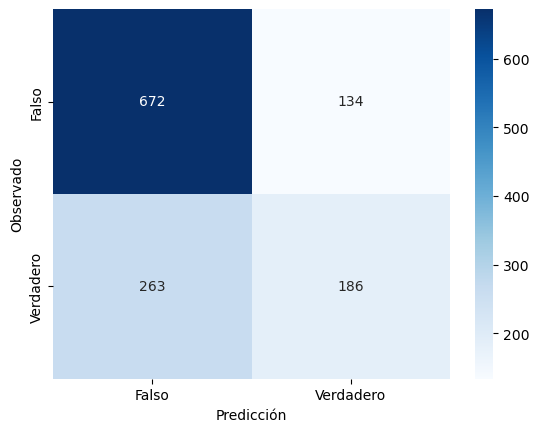

In [50]:
mc_log_plot = sns.heatmap(matriz_confusion_log, annot=True, fmt='g', cmap='Blues', xticklabels=['Falso', 'Verdadero'], yticklabels=['Falso', 'Verdadero'])
mc_log_plot.set_xlabel('Predicción')
mc_log_plot.set_ylabel('Observado')

plt.savefig('../outputs/mc_logit.png', format='png')
plt.show() 
plt.close()

AUC: 0.624000397906569249
[2 1 0]
[0.        0.1662531 1.       ]
[0.        0.4142539 1.       ]


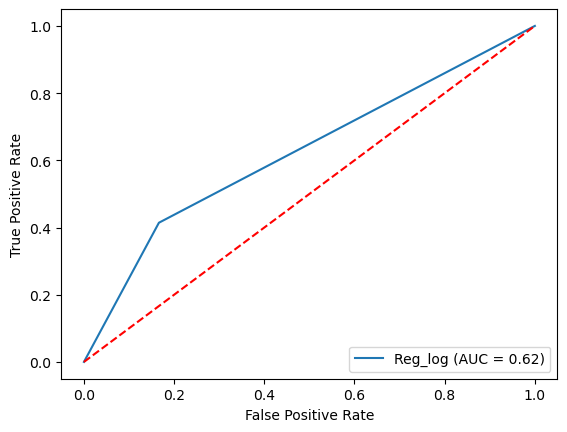

In [34]:
# Curva ROC y AUC score
auc_log = roc_auc_score(y_test, y_test_pred)
print('AUC: %.18f' % auc_log) 

fpr, tpr, thresholds = roc_curve(y_test, y_test_pred)
np.set_printoptions(suppress = True)
print(thresholds)
print(fpr)
print(tpr)

display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=auc_log, estimator_name='Reg_log')
display.plot()  
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.show()

#### KNN

In [35]:
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=3)

In [36]:
# Predecimos con el modelo lda sobre las X test
y_pred_knn = knn.predict(X_test)

c:\Users\Ronny\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


In [37]:
matriz_confusion_knn = confusion_matrix(y_test, y_pred_knn)
ac_knn = accuracy_score(y_test, y_pred_knn) 

print('Matriz de confusión:\n', matriz_confusion_knn)
print('Accuracy Score: %.3f' %ac_knn)

Matriz de confusión:
 [[634 172]
 [192 257]]
Accuracy Score: 0.710


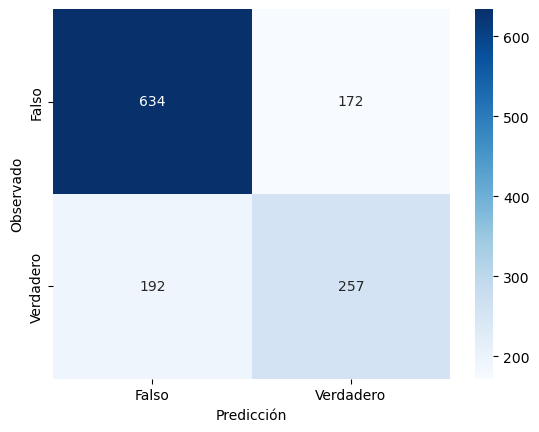

In [51]:
# Graficamos la matriz de confusión
mc_knn_plot = sns.heatmap(matriz_confusion_knn, annot=True, fmt='g', cmap='Blues', xticklabels=['Falso', 'Verdadero'], yticklabels=['Falso', 'Verdadero'])
mc_knn_plot.set_xlabel('Predicción')
mc_knn_plot.set_ylabel('Observado')

plt.savefig('../outputs/mc_knn.png', format='png')
plt.show() 
plt.close()


 AUC KNN: 0.68 



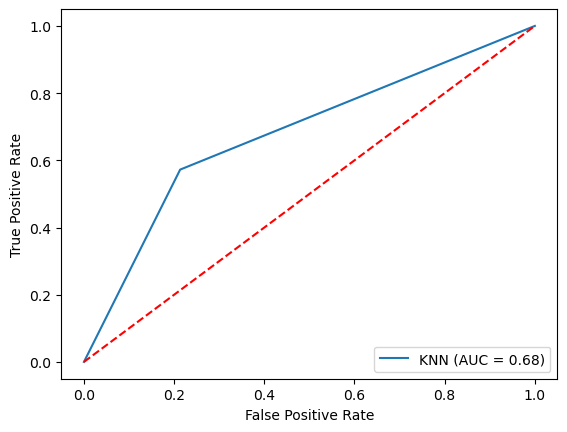

In [39]:
# AUC y KNN
auc_knn = roc_auc_score(y_test, y_pred_knn)
print('\n','AUC KNN:', '%.2f' % auc_knn,'\n')

fpr_knn, tpr_knn, thresholds_knn = roc_curve(y_test, y_pred_knn)

display = RocCurveDisplay(fpr=fpr_knn, tpr=tpr_knn, roc_auc=auc_knn, estimator_name='KNN')
display.plot()  
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.show() 

#### Análisis de discriminante lineal

In [40]:
lda = LinearDiscriminantAnalysis(n_components=1)
lda = lda.fit(X_train, y_train)
# Predecimos con el modelo de ADL sobre las X test
y_pred_lda = lda.predict(X_test) 

In [41]:
matriz_confusion_lda = confusion_matrix(y_test, y_pred_lda)

print('Confusion Matrix :')
print(matriz_confusion_lda)

ac_lda= accuracy_score(y_test, y_pred_lda)
print('\n','Accuracy Score LDA:','%.3f' % ac_lda) 

Confusion Matrix :
[[640 166]
 [145 304]]

 Accuracy Score LDA: 0.752


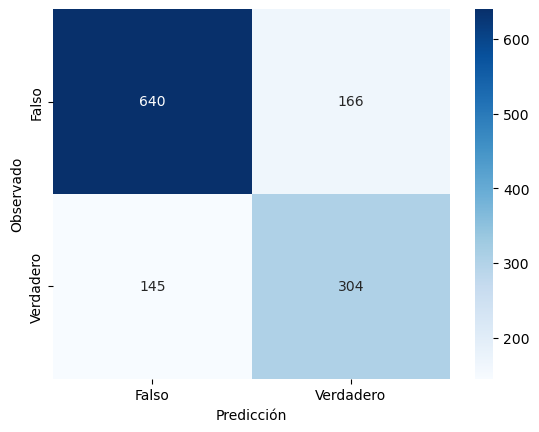

In [52]:
mc_lda_plot = sns.heatmap(matriz_confusion_lda, annot=True, fmt='g', cmap='Blues', xticklabels=['Falso', 'Verdadero'], yticklabels=['Falso', 'Verdadero'])
mc_lda_plot.set_xlabel('Predicción')
mc_lda_plot.set_ylabel('Observado')

plt.savefig('../outputs/mc_lda.png', format='png')
plt.show() 
plt.close()


 AUC LDA: 0.74 



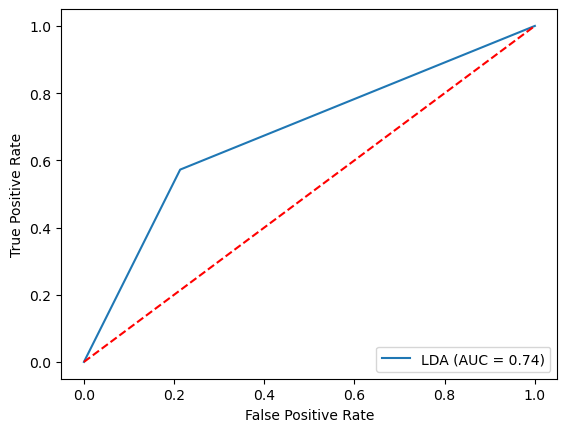

In [43]:
# AUC y curva ROC
auc_lda = roc_auc_score(y_test, y_pred_lda)
print('\n','AUC LDA:', '%.2f' % auc_lda,'\n')

fpr_lda, tpr_lda, thresholds_lda = roc_curve(y_test, y_pred_lda)

display = RocCurveDisplay(fpr=fpr_knn, tpr=tpr_knn, roc_auc=auc_lda, estimator_name='LDA')
display.plot()  
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.show() 

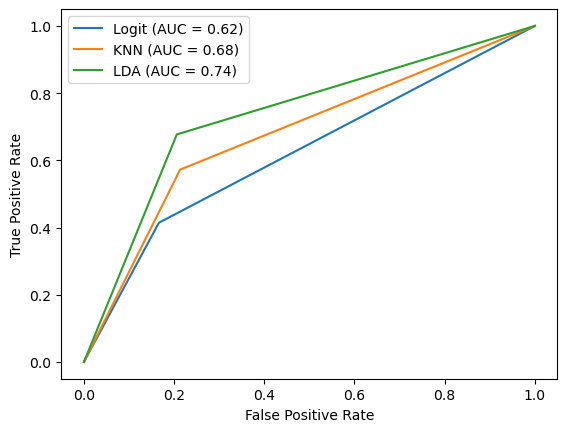

In [49]:
# Graficamos las tres curvas ROC juntas

# Plot the ROC curves on the same axis
plt.plot(fpr, tpr, label=f'Logit (AUC = {auc_log:.2f})')
plt.plot(fpr_knn, tpr_knn, label=f'KNN (AUC = {auc_knn:.2f})')
plt.plot(fpr_lda, tpr_lda, label=f'LDA (AUC = {auc_lda:.2f})')

# Add labels and legend
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()

# Show the plot
plt.savefig('../outputs/roc_curves.png', format='png')
plt.show()
plt.close()